## Import

In [1]:
# -*- coding: utf-8 -*-
import random
import pandas as pd
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models

from tqdm.auto import tqdm
import random
import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Hyperparameter Setting

In [3]:
CFG = {
    'IMG_SIZE':256,
    'EPOCHS':12,
    'LEARNING_RATE':1e-3, # default = 3e-4(0.0003)
    'BATCH_SIZE':32,
    'SEED':42,
    'BETA':1.0 #cutmix hyperparameter
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [5]:
df = pd.read_csv('/kaggle/input/dacon-data/train.csv')
df.head()

,img_id,img_path,airplane,airport,bare soil,baseball diamond,basketball court,beach,bridge,buildings,...,tanks,tennis court,terrace,track,trail,transmission tower,trees,water,wetland,wind turbine
0,000L8TYE,./train/000L8TYE.jpg,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
1,0035QTK9,./train/0035QTK9.jpg,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,00470HEH,./train/00470HEH.jpg,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,004CCB2Q,./train/004CCB2Q.jpg,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,005AY4ES,./train/005AY4ES.jpg,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0


## Train / Validation Split

In [6]:
df = df.sample(frac=1)
train_len = int(len(df))
train_df = df[:train_len]
#val_df = df[train_len:]

In [7]:
(train_df.shape, )

((65496, 62),)

## Data Preprocessing

In [8]:
def get_labels(df):
    return df.iloc[:,2:].values

train_labels = get_labels(train_df)
#val_labels = get_labels(val_df)

In [9]:
(train_labels.shape, )

((65496, 60),)

## CustomDataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transform=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]

        # PIL 이미지로 불러오기
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        
        if self.label_list is not None:
            label = torch.tensor(self.label_list[index], dtype=torch.float32)
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [11]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees = 5, translate = (0.0, 0.0), scale = (0.8, 1.2), shear = 5),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE']), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE']), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
train_dataset = CustomDataset('/kaggle/input/dacon-data/'+train_df['img_path'].values, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=2)

#val_dataset = CustomDataset('/kaggle/input/dacon-data/'+val_df['img_path'].values, val_labels, test_transform)
#val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=2)


## Cutmix Augmentation

In [13]:
def rand_bbox(size, lam): # size : [B, C, W, H]
    W = size[2] # 이미지의 width
    H = size[3] # 이미지의 height
    cut_rat = np.sqrt(1. - lam)  # 패치 크기의 비율 정하기
    cut_w = int(W * cut_rat)  # 패치의 너비
    cut_h = int(H * cut_rat)  # 패치의 높이

    # uniform
    # 기존 이미지의 크기에서 랜덤하게 값을 가져옵니다.(중간 좌표 추출)
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # 패치 부분에 대한 좌표값을 추출합니다.
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


In [14]:
X,y = next(iter(train_loader))
X = X.to(device)

lam = np.random.beta(1.0, 1.0)  # 베타 분포에서 lam 값을 가져옵나다.
rand_index = torch.randperm(X.size()[0]).to(device) # batch_size 내의 인덱스가 랜덤하게 셔플됩니다.

print(lam)
print(rand_index)

0.6947686574002817
tensor([10, 19, 12, 30, 18,  7,  0, 21,  6, 31, 23, 27, 11,  5, 17,  1, 13, 28,
        25, 20,  9, 16,  8, 22, 15,  2, 26,  4, 24,  3, 14, 29],
       device='cuda:0')


0.7735595703125


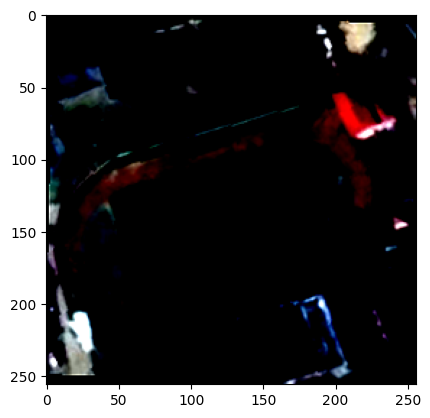

In [15]:
import matplotlib.pyplot as plt

bbx1, bby1, bbx2, bby2 = rand_bbox(X.size(), lam)
#X[:,:,bbx1:bbx2, bby1:bby2] = X[rand_index,:,bbx1:bbx2, bby1:bby2]
lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (X.size()[-1] * X.size()[-2]))
print(lam)
plt.imshow(X[0].permute(1, 2, 0).cpu())

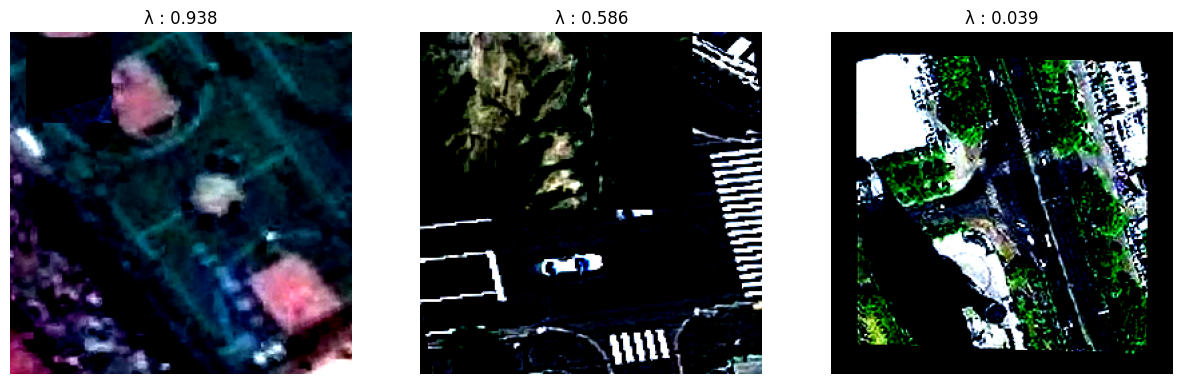

In [16]:
def cutmix_plot(train_loader):
    fig , axes = plt.subplots(1,3)
    fig.set_size_inches(15,12)
    
    for i in range(3):
        for inputs, targets in train_loader:
            inputs = inputs
            targets = targets
            break

        lam = np.random.beta(1.0, 1.0) 
        rand_index = torch.randperm(inputs.size()[0])
        bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
        inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
        axes[i].imshow(inputs[1].permute(1, 2, 0).cpu())
        axes[i].set_title(f'λ : {np.round(lam,3)}')
        axes[i].axis('off')
    return

cutmix_plot(train_loader)

## Model Define

In [17]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=60):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_v2_s(pretrained = True) #ImageNet pretrained
        #self.classifier = nn.Linear(1000, num_classes) #1
        
        self.classifier2 = nn.Sequential(nn.Linear(1000, 512),
                                         nn.ReLU(),
                                         nn.Dropout(0.0),
                                         nn.BatchNorm1d(512),
                                         nn.Linear(512, num_classes) 
                                        )
    def forward(self, x):
        x = self.backbone(x)
        #x = F.sigmoid(self.classifier(x)) #default
        x = (self.classifier2(x)) ## F.sigmoid를 쓰지 않은 이유는, Focal_Loss를 사용해야하는 특성 때문입니다.
        
        return x

## Focal Loss Implementation

In [18]:
class FocalLossV1(nn.Module):

    def __init__(self,
                 alpha=0.25,
                 gamma=2,#default = 2
                 temperature = 1.0,
                 reduction='mean'):
        super(FocalLossV1, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.crit = nn.BCEWithLogitsLoss()
        self.temperature = temperature

    def forward(self, logits, label):
        '''
        Usage is same as nn.BCEWithLogits:
            >>> criteria = FocalLossV1()
            >>> logits = torch.randn(8, 19, 384, 384)
            >>> lbs = torch.randint(0, 2, (8, 19, 384, 384)).float()
            >>> loss = criteria(logits, lbs)
        '''
        logits = logits / self.temperature
        probs = torch.sigmoid(logits)
        coeff = torch.abs(label - probs).pow(self.gamma).neg()
        log_probs = torch.where(logits >= 0,
                F.softplus(logits, -1, 50),
                logits - F.softplus(logits, 1, 50))
        log_1_probs = torch.where(logits >= 0,
                -logits + F.softplus(logits, -1, 50),
                -F.softplus(logits, 1, 50))
        loss = label * self.alpha * log_probs + (1. - label) * (1. - self.alpha) * log_1_probs
        loss = loss * coeff

        if self.reduction == 'mean':
            loss = loss.mean()
        if self.reduction == 'sum':
            loss = loss.sum()
        return loss

## Train

In [19]:
def train(model, optimizer, scheduler, train_loader, device):
    model.to(device)
    #criterion = nn.BCELoss().to(device)
    criterion = FocalLossV1(alpha=0.25,gamma=2,temperature=0.6,reduction='mean').to(device)
    
    best_val_loss = float('inf') 
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            if CFG["BETA"] > 0 and np.random.random()>0.7: # cutmix 작동될 확률      
                lam = np.random.beta(CFG["BETA"], CFG["BETA"])
                rand_index = torch.randperm(imgs.size()[0]).to(device)
                target_a = labels
                target_b = labels[rand_index]            
                bbx1, bby1, bbx2, bby2 = rand_bbox(imgs.size(), lam)
                imgs[:, :, bbx1:bbx2, bby1:bby2] = imgs[rand_index, :, bbx1:bbx2, bby1:bby2]
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (imgs.size()[-1] * imgs.size()[-2]))
                output = model(imgs)
                loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
            
            else:
                output = model(imgs)
                loss = criterion(output, labels)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss.append(loss.item())
                    
        #_val_loss = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] ')
            
        #if best_val_loss > _val_loss:
        #    best_val_loss = _val_loss
        #    best_model = model
    
    return model

In [20]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            
            loss = criterion(probs, labels)
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
    
    return _val_loss

## Run!!

In [21]:
model = BaseModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['LEARNING_RATE'], betas=(0.9, 0.999), eps=1e-08, 
                              weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, max_lr=1e-3, base_lr=1e-7,step_size_up=400, 
                                              step_size_down=3600,cycle_momentum=False,mode='triangular2')
infer_model = train(model, optimizer, scheduler, train_loader, device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 210MB/s]


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.02576] 


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.00943] 


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.01026] 


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.00814] 


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.00828] 


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.00714] 


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.00696] 


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.00643] 


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.00630] 


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.00605] 


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.00590] 


  0%|          | 0/2047 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.00589] 


## Inference

In [22]:
test = pd.read_csv('/kaggle/input/dacon-data/test.csv')

In [23]:
test_dataset = CustomDataset('/kaggle/input/dacon-data/'+test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [24]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            probs = (model(imgs)) #MAP의 랭킹을 고려한다는 특성 상, 로짓(logit)점수를 제출하여도 정상적으로 채점됨을 이전에 검증하였기 떄문에 
                                  #후에 앙상블의 더극적인 효과를 위해 시그모이드를 보류한 채, 로짓점수로 출력시킵니다.

            probs  = probs.cpu().detach().numpy()
            predictions += probs.tolist()
    return predictions

In [25]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/1365 [00:00<?, ?it/s]

## Submission

In [26]:
submit = pd.read_csv('/kaggle/input/dacon-data/sample_submission.csv')

In [27]:
submit.iloc[:,1:] = preds
submit.head()

,img_id,airplane,airport,bare soil,baseball diamond,basketball court,beach,bridge,buildings,cars,...,tanks,tennis court,terrace,track,trail,transmission tower,trees,water,wetland,wind turbine
0,000TT5XV,-1.911899,-1.954699,-0.488376,-1.763181,-2.118784,-2.441106,-1.848200,0.591900,-0.003995,...,-2.189838,-1.779002,-1.961218,-1.503099,-1.442943,-1.826415,-1.676373,0.997745,-1.988021,-2.279757
1,0013XXDH,-2.233561,-2.082494,-0.198643,-1.848149,-2.143579,-2.522058,-2.529055,-0.871042,-1.448762,...,-2.441466,-2.115333,-1.840636,-2.304768,-0.906562,-2.107035,0.613330,-1.636994,-2.520901,-2.083972
2,001Z4YNH,-2.423120,-2.201162,-0.197347,-1.764370,-2.017040,-2.333542,-1.945163,0.563248,0.449109,...,-1.855865,1.096447,-1.557391,-1.704307,-1.459136,-1.748766,1.158533,-1.106771,-2.232529,-2.715221
3,00297F36,-2.518573,-2.553078,-0.832817,-2.437234,-1.948298,-2.822430,-2.257405,0.697765,0.891537,...,-0.316660,-0.350333,-0.152319,-0.393625,-0.329067,-0.278598,1.035382,-1.345762,-2.242752,-2.402065
4,002GFJL0,-2.030896,-1.935785,0.027966,-1.713490,-1.928962,-2.251975,-2.055628,1.037258,-0.105588,...,-2.213332,-1.748891,-1.945893,-1.747214,-1.569989,-1.756760,-0.855138,0.720095,-2.074341,-2.392896


In [28]:
submit.to_csv('/kaggle/working/model_1.csv', index=False)


In [29]:
submit

,img_id,airplane,airport,bare soil,baseball diamond,basketball court,beach,bridge,buildings,cars,...,tanks,tennis court,terrace,track,trail,transmission tower,trees,water,wetland,wind turbine
0,000TT5XV,-1.911899,-1.954699,-0.488376,-1.763181,-2.118784,-2.441106,-1.848200,0.591900,-0.003995,...,-2.189838,-1.779002,-1.961218,-1.503099,-1.442943,-1.826415,-1.676373,0.997745,-1.988021,-2.279757
1,0013XXDH,-2.233561,-2.082494,-0.198643,-1.848149,-2.143579,-2.522058,-2.529055,-0.871042,-1.448762,...,-2.441466,-2.115333,-1.840636,-2.304768,-0.906562,-2.107035,0.613330,-1.636994,-2.520901,-2.083972
2,001Z4YNH,-2.423120,-2.201162,-0.197347,-1.764370,-2.017040,-2.333542,-1.945163,0.563248,0.449109,...,-1.855865,1.096447,-1.557391,-1.704307,-1.459136,-1.748766,1.158533,-1.106771,-2.232529,-2.715221
3,00297F36,-2.518573,-2.553078,-0.832817,-2.437234,-1.948298,-2.822430,-2.257405,0.697765,0.891537,...,-0.316660,-0.350333,-0.152319,-0.393625,-0.329067,-0.278598,1.035382,-1.345762,-2.242752,-2.402065
4,002GFJL0,-2.030896,-1.935785,0.027966,-1.713490,-1.928962,-2.251975,-2.055628,1.037258,-0.105588,...,-2.213332,-1.748891,-1.945893,-1.747214,-1.569989,-1.756760,-0.855138,0.720095,-2.074341,-2.392896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43660,ZZXLYV5U,-2.239142,-2.301383,-1.422222,-1.832382,-2.080375,-2.278980,-1.855759,-1.329585,-1.476026,...,-2.395911,-2.274667,-1.845312,-1.976705,-0.271194,-1.942094,-0.610023,-1.309877,-2.439631,-1.870598
43661,ZZY67M9P,-1.770867,-2.058730,-0.894210,-2.114801,-1.839257,-2.429590,-2.103646,0.804387,0.188119,...,-2.011704,-1.867833,-2.056246,-1.764705,-1.563181,-1.754343,-0.484289,-1.656768,-2.178261,-2.145162
43662,ZZYN9M9Y,-2.821478,-2.667116,-1.341161,-2.762270,-2.518977,-2.976911,-2.856058,-2.629628,-2.304698,...,-3.105646,-2.715718,-2.593202,-2.756084,-2.137330,-2.252811,-1.418080,-1.283441,-2.885409,-2.686136
43663,ZZYQ8XEV,-2.512389,-2.321976,0.698447,0.978248,-1.904965,-2.814539,-2.003234,0.453492,-1.067149,...,-2.392527,-2.129380,-2.071026,-1.819953,-1.377137,-1.910936,1.139118,-1.510811,-2.307756,-2.246160


In [30]:
import numpy as np
from IPython.display import FileLink
import os

result = np.array([0.0])
np.save("/kaggle/working/embedding",submit)
os.chdir(r'/kaggle/working')
FileLink(r'model_1.csv') #캐글 데이터 다운로드 버튼이 오작동해서 링크를 통해 결과물 다운받았습니다.

/kaggle/working/model_1.csv

In [31]:
# 모델 가중치 저장
torch.save(infer_model.state_dict(), 'model1_weights.pth')
np.save("/kaggle/working/embedding",submit)
os.chdir(r'/kaggle/working')
FileLink(r'model1_weights.pth')

/kaggle/working/model1_weights.pth